In [169]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['font.family'] = 'serif'

In [170]:
network = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_2015.values)

network.add("Bus",
            "electricity bus")

network.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

In [171]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
country='GBR'
print(df_elec[country].head())

utc_time
2015-01-01 00:00:00+00:00    29059.0
2015-01-01 01:00:00+00:00    28663.0
2015-01-01 02:00:00+00:00    26626.0
2015-01-01 03:00:00+00:00    24778.0
2015-01-01 04:00:00+00:00    23212.0
Name: GBR, dtype: float64


In [172]:
# add load to the bus
network.add("Load",
            "load",
            bus="electricity bus",
            p_set=df_elec[country].values)

Index(['load'], dtype='object')

In [173]:
network.loads_t.p_set

Load,load
snapshot,
2015-01-01 00:00:00,29059.0
2015-01-01 01:00:00,28663.0
2015-01-01 02:00:00,26626.0
2015-01-01 03:00:00,24778.0
2015-01-01 04:00:00,23212.0
...,...
2015-12-31 19:00:00,35944.0
2015-12-31 20:00:00,33128.0
2015-12-31 21:00:00,30488.0


In [174]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [175]:
# CAPEX values for different technologies (in €/MW)
offshoreWind_capex = 2.8e6
onshoreWind_capex = 1.4e6
solar_capex = 628e3
ccgt_capex = 1.04e6
nuclear_capex = 11.08e6

# add the different carriers, only gas emits CO2
network.add("Carrier", "gas", co2_emissions=0.2019) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")

# add onshore wind generator
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_windOnshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_onshorewind = annuity(25,0.07)*onshoreWind_capex #*(1+0.033) # in €/MW !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_windOnshore.values)

# add offshore wind generator
df_offshore = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshore.index = pd.to_datetime(df_offshore.index)
CF_windOffshore = df_offshore[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_offshore = annuity(25,0.07)*offshoreWind_capex #*(1+0.033) # in €/MW !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
network.add("Generator",
            "offshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshore,
            marginal_cost = 0,
            p_max_pu = CF_windOffshore.values)

# add solar PV generator
df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_solar = annuity(25,0.07)*solar_capex*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)

# # add OCGT (Open Cycle Gas Turbine) generator
# capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
# fuel_cost = 21.6 # in €/MWh_th
# efficiency = 0.39 # MWh_elec/MWh_th
# marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
# network.add("Generator",
#             "OCGT",
#             bus="electricity bus",
#             p_nom_extendable=True,
#             carrier="gas",
#             #p_nom_max=1000,
#             capital_cost = capital_cost_OCGT,
#             marginal_cost = marginal_cost_OCGT)

# add CCGT (Combine Cycle Gas Turbine) generator
capital_cost_CCGT = annuity(30,0.07)*ccgt_capex#*(1+0.033) # in €/MW
fuel_cost = 30.32 # in €/MWh_th
efficiency = 0.5 # MWh_elec/MWh_th
marginal_cost_CCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "CCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_CCGT,
            marginal_cost = marginal_cost_CCGT)

# add nuclear generator
capital_cost_nuclear = annuity(40,0.07)*nuclear_capex#*(1+0.033) # in €/MW
fuel_cost = 6.2 # in €/MWh_th
efficiency = 0.33 # MWh_elec/MWh_th
marginal_cost_nuclear = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "nuclear",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="nuclear",
            #p_nom_max=1000,
            capital_cost = capital_cost_nuclear,
            marginal_cost = marginal_cost_nuclear)

Index(['nuclear'], dtype='object')

In [176]:
network.generators_t.p_max_pu

Generator,offshorewind,onshorewind,solar
snapshot,,,
2015-01-01 00:00:00,0.601,0.606,0.0
2015-01-01 01:00:00,0.569,0.610,0.0
2015-01-01 02:00:00,0.538,0.592,0.0
2015-01-01 03:00:00,0.539,0.570,0.0
2015-01-01 04:00:00,0.561,0.552,0.0
...,...,...,...
2015-12-31 19:00:00,0.735,0.508,0.0
2015-12-31 20:00:00,0.666,0.426,0.0
2015-12-31 21:00:00,0.554,0.336,0.0


In [ ]:
co2_limit=1000000 #tonCO2
network.add("GlobalConstraint",
            "co2_limit",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_limit)

In [177]:
network.optimize(solver_name='gurobi')

Index(['offshorewind', 'nuclear'], dtype='object', name='Generator')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 32.69it/s]
INFO:linopy.io: Writing time: 0.41s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-l2yshgio.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-l2yshgio.lp


Reading time = 0.10 seconds


INFO:gurobipy:Reading time = 0.10 seconds


obj: 96365 rows, 43805 columns, 170959 nonzeros


INFO:gurobipy:obj: 96365 rows, 43805 columns, 170959 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))


INFO:gurobipy:


CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]


Thread count: 14 physical cores, 20 logical processors, using up to 20 threads


INFO:gurobipy:Thread count: 14 physical cores, 20 logical processors, using up to 20 threads


INFO:gurobipy:


Optimize a model with 96365 rows, 43805 columns and 170959 nonzeros


INFO:gurobipy:Optimize a model with 96365 rows, 43805 columns and 170959 nonzeros


Model fingerprint: 0xa584d8fe


INFO:gurobipy:Model fingerprint: 0xa584d8fe


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [2e+01, 8e+05]


INFO:gurobipy:  Objective range  [2e+01, 8e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 5e+04]


INFO:gurobipy:  RHS range        [2e+04, 5e+04]


Presolve removed 48051 rows and 4246 columns


INFO:gurobipy:Presolve removed 48051 rows and 4246 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 48314 rows, 39559 columns, 118662 nonzeros


INFO:gurobipy:Presolved: 48314 rows, 39559 columns, 118662 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 7.911e+04


INFO:gurobipy: AA' NZ     : 7.911e+04


 Factor NZ  : 3.788e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 3.788e+05 (roughly 40 MB of memory)


 Factor Ops : 3.119e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.119e+06 (less than 1 second per iteration)


 Threads    : 12


INFO:gurobipy: Threads    : 12


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.44373339e+11  0.00000000e+00  3.20e+05 0.00e+00  1.47e+08     0s


INFO:gurobipy:   0   2.44373339e+11  0.00000000e+00  3.20e+05 0.00e+00  1.47e+08     0s


   1   3.65689118e+11 -5.15336395e+11  5.10e+04 4.10e+02  3.04e+07     0s


INFO:gurobipy:   1   3.65689118e+11 -5.15336395e+11  5.10e+04 4.10e+02  3.04e+07     0s


   2   2.38835260e+11 -2.19268987e+11  5.82e-11 3.26e-09  3.86e+06     0s


INFO:gurobipy:   2   2.38835260e+11 -2.19268987e+11  5.82e-11 3.26e-09  3.86e+06     0s


   3   1.14807043e+11 -2.31112111e+10  8.73e-11 2.24e-09  1.16e+06     0s


INFO:gurobipy:   3   1.14807043e+11 -2.31112111e+10  8.73e-11 2.24e-09  1.16e+06     0s


   4   5.40228334e+10  5.14627603e+09  2.04e-10 5.68e-10  4.12e+05     0s


INFO:gurobipy:   4   5.40228334e+10  5.14627603e+09  2.04e-10 5.68e-10  4.12e+05     0s


   5   4.53741095e+10  1.04925202e+10  1.02e-09 8.37e-10  2.94e+05     0s


INFO:gurobipy:   5   4.53741095e+10  1.04925202e+10  1.02e-09 8.37e-10  2.94e+05     0s


   6   3.35354030e+10  1.30915939e+10  5.24e-10 6.62e-10  1.72e+05     0s


INFO:gurobipy:   6   3.35354030e+10  1.30915939e+10  5.24e-10 6.62e-10  1.72e+05     0s


   7   2.83647586e+10  1.56266575e+10  3.06e-10 2.60e-13  1.07e+05     0s


INFO:gurobipy:   7   2.83647586e+10  1.56266575e+10  3.06e-10 2.60e-13  1.07e+05     0s


   8   2.56712493e+10  1.68196370e+10  1.75e-10 5.85e-11  7.46e+04     0s


INFO:gurobipy:   8   2.56712493e+10  1.68196370e+10  1.75e-10 5.85e-11  7.46e+04     0s


   9   2.41018455e+10  1.77518363e+10  1.16e-10 2.52e-09  5.35e+04     0s


INFO:gurobipy:   9   2.41018455e+10  1.77518363e+10  1.16e-10 2.52e-09  5.35e+04     0s


  10   2.30589728e+10  1.83736467e+10  8.73e-11 9.68e-10  3.95e+04     0s


INFO:gurobipy:  10   2.30589728e+10  1.83736467e+10  8.73e-11 9.68e-10  3.95e+04     0s


  11   2.24170944e+10  1.89194766e+10  5.82e-11 4.80e-10  2.95e+04     0s


INFO:gurobipy:  11   2.24170944e+10  1.89194766e+10  5.82e-11 4.80e-10  2.95e+04     0s


  12   2.19128322e+10  1.95231365e+10  2.91e-11 1.67e-10  2.01e+04     0s


INFO:gurobipy:  12   2.19128322e+10  1.95231365e+10  2.91e-11 1.67e-10  2.01e+04     0s


  13   2.17299541e+10  1.98237424e+10  2.91e-11 3.35e-10  1.61e+04     0s


INFO:gurobipy:  13   2.17299541e+10  1.98237424e+10  2.91e-11 3.35e-10  1.61e+04     0s


  14   2.16868334e+10  1.99519822e+10  2.91e-11 7.93e-10  1.46e+04     0s


INFO:gurobipy:  14   2.16868334e+10  1.99519822e+10  2.91e-11 7.93e-10  1.46e+04     0s


  15   2.13908551e+10  2.00362891e+10  2.91e-11 2.00e-09  1.14e+04     0s


INFO:gurobipy:  15   2.13908551e+10  2.00362891e+10  2.91e-11 2.00e-09  1.14e+04     0s


  16   2.11752836e+10  2.01645586e+10  2.91e-11 4.00e-10  8.52e+03     0s


INFO:gurobipy:  16   2.11752836e+10  2.01645586e+10  2.91e-11 4.00e-10  8.52e+03     0s


  17   2.11090674e+10  2.01955097e+10  2.91e-11 1.51e-09  7.70e+03     1s


INFO:gurobipy:  17   2.11090674e+10  2.01955097e+10  2.91e-11 1.51e-09  7.70e+03     1s


  18   2.10707398e+10  2.02311295e+10  8.00e-11 7.42e-10  7.08e+03     1s


INFO:gurobipy:  18   2.10707398e+10  2.02311295e+10  8.00e-11 7.42e-10  7.08e+03     1s


  19   2.10243145e+10  2.02977206e+10  6.55e-11 1.24e-09  6.12e+03     1s


INFO:gurobipy:  19   2.10243145e+10  2.02977206e+10  6.55e-11 1.24e-09  6.12e+03     1s


  20   2.09030221e+10  2.03580311e+10  6.28e-10 4.15e-10  4.59e+03     1s


INFO:gurobipy:  20   2.09030221e+10  2.03580311e+10  6.28e-10 4.15e-10  4.59e+03     1s


  21   2.08628819e+10  2.03719966e+10  5.60e-10 1.56e-09  4.14e+03     1s


INFO:gurobipy:  21   2.08628819e+10  2.03719966e+10  5.60e-10 1.56e-09  4.14e+03     1s


INFO:gurobipy:


Barrier performed 21 iterations in 0.62 seconds (0.47 work units)


INFO:gurobipy:Barrier performed 21 iterations in 0.62 seconds (0.47 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   32405    2.0531353e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   32405    2.0531353e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 32405 iterations and 0.66 seconds (1.79 work units)


INFO:gurobipy:Solved in 32405 iterations and 0.66 seconds (1.79 work units)


Optimal objective  2.053135332e+10


INFO:gurobipy:Optimal objective  2.053135332e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96365 duals
Objective: 2.05e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [178]:
print(network.objective/1000000) #in 10^6 €

20531.353324086813


In [179]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
load    72.755859
dtype: float64


In [180]:
network.generators.p_nom_opt # in MW

Generator
onshorewind     52036.876356
offshorewind        0.000000
solar               0.000000
CCGT            49825.156182
nuclear             0.000000
Name: p_nom_opt, dtype: float64

C:\Users\carlo\AppData\Local\Temp\ipykernel_9200\2187985169.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start="2015-01-01", periods=96, freq='H')


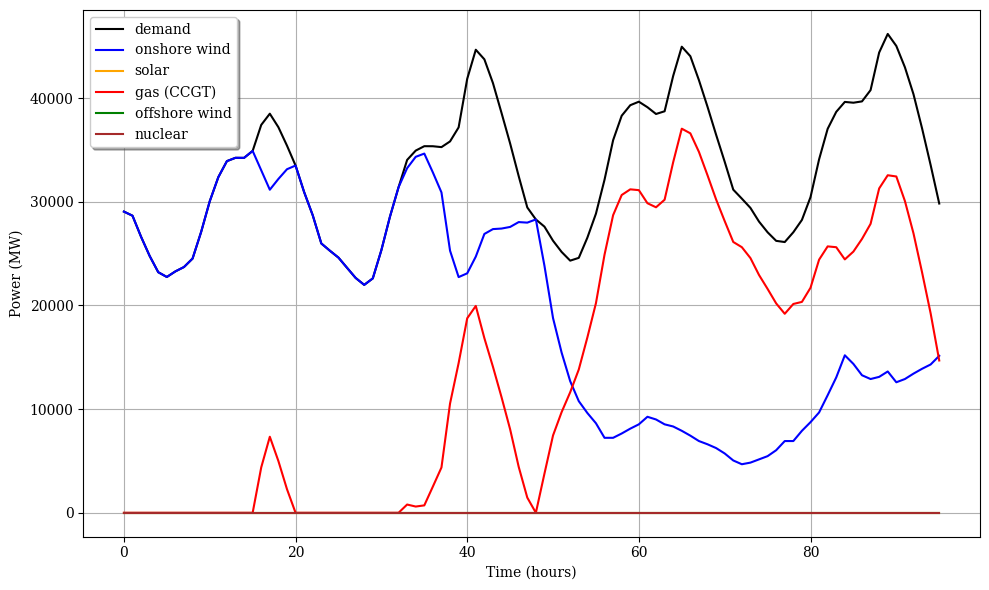

In [ ]:
hours = pd.date_range(start="2015-01-01", periods=96, freq='H')
demand = network.loads_t.p['load'][0:96].values
onshore_wind = network.generators_t.p['onshorewind'][0:96].values
solar = network.generators_t.p['solar'][0:96].values    
gas_ccgt = network.generators_t.p['CCGT'][0:96].values
offshore_wind = network.generators_t.p['offshorewind'][0:96].values
nuclear = network.generators_t.p['nuclear'][0:96].values

plt.figure(figsize=(10, 6))
plt.plot(demand, color='black', label='demand')
plt.plot(onshore_wind, color='blue', label='onshore wind')
plt.plot(solar, color='orange', label='solar')
plt.plot(gas_ccgt, color='red', label='gas (CCGT)')
plt.plot(offshore_wind, color='green', label='offshore wind')
plt.plot(nuclear, color='brown', label='nuclear')
plt.legend(fancybox=True, shadow=True, loc='best')
plt.xlabel('Time (hours)')
plt.ylabel('Power (MW)')
#plt.title('Energy Production and Demand')
# plt.xticks(rotation=45)
plt.grid(True)

# Improve x-axis ticks
# plt.gca().xaxis.set_major_locator(plt.MultipleLocator(12))
# plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(3))
# plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))

plt.tight_layout()


Text(0.5, 1.07, 'Electricity mix')

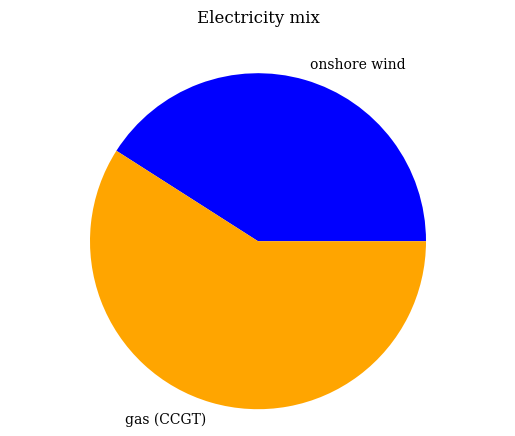

In [ ]:
labels = ['onshore wind',
          'gas (CCGT)']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['CCGT'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['offshorewind'].sum(),
         network.generators_t.p['nuclear'].sum()
]

colors=['blue', 'orange', 'brown', 'green', 'red']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

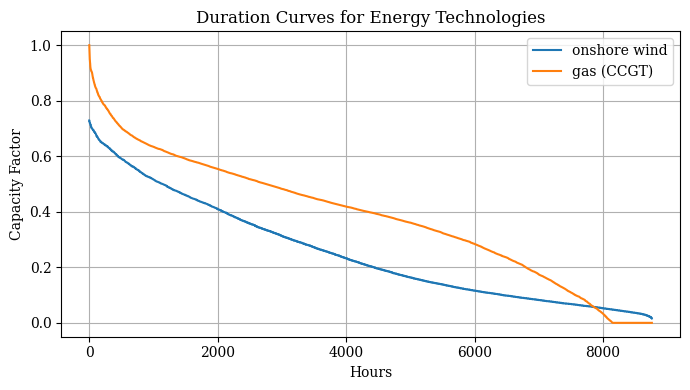

In [ ]:
# Capacity factor calculation
capacity_factors = {
    "onshore wind": network.generators_t.p['onshorewind'] / network.generators.p_nom_opt['onshorewind'],
    "gas (CCGT)": network.generators_t.p['CCGT'] / network.generators.p_nom_opt['CCGT'],
    "solar": network.generators_t.p['solar'] / network.generators.p_nom_opt['solar'],
    "offshore wind": network.generators_t.p['offshorewind'] / network.generators.p_nom_opt['offshorewind'],
    "nuclear": network.generators_t.p['nuclear'] / network.generators.p_nom_opt['nuclear']
}

# Sorting data for duration curve plot
duration_curves = {
    tech: np.sort(data)[::-1]
    for tech, data in capacity_factors.items()
}

# Plotting the duration curves
plt.figure(figsize=(7, 4))
for tech, data in duration_curves.items():
    plt.plot(data, label=tech)

plt.title('Duration Curves for Energy Technologies')
plt.xlabel('Hours')
plt.ylabel('Capacity Factor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
